In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_63046/3150187442.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Import the Csv's
payments_df = pd.read_csv('/mnt/c/Users/kpali/Downloads/Payments.csv')
clients_df = pd.read_csv('/mnt/c/Users/kpali/Downloads/Clients.csv')

In [3]:
# Shape of each dataset
print(payments_df.shape)
print(clients_df.shape)

(25559, 6)
(1287, 3)


In [4]:
# Data types of each column
print(payments_df.dtypes)
print(clients_df.dtypes)

transaction_id        int64
contract_id           int64
client_id             int64
transaction_date      int64
payment_amt         float64
payment_code         object
dtype: object
client_id                   int64
entity_type                object
entity_year_established     int64
dtype: object


In [5]:
# Number of nulls in columns for each dataframe
payments_df_null_counts = payments_df.isnull().sum()
clients_df_null_counts = clients_df.isnull().sum()
print(payments_df_null_counts)
print(clients_df_null_counts)

transaction_id      0
contract_id         0
client_id           0
transaction_date    0
payment_amt         0
payment_code        0
dtype: int64
client_id                  0
entity_type                0
entity_year_established    0
dtype: int64


In [6]:
# Check there are no payment_amt less than 0
(payments_df['payment_amt'] < 0).sum()

2

In [7]:
# Rows with payment_amt < 0
payments_df[payments_df['payment_amt'] < 0]

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
5271,16270,564,259,1522778905,-55.00,PAYMENT
20089,18574,451,937,1525370908,-136.66,PAYMENT


In [8]:
# Filter records with payment_amt >= 0
payments_df = payments_df[payments_df['payment_amt'] >= 0]

In [9]:
# Convert epoch timestamp for transaction_date to a datetime value
payments_df['transaction_date'] = pd.to_datetime(payments_df['transaction_date'], unit = 's')

In [10]:
# Preview payments_df
payments_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
0,20175,927,1,2018-05-22 18:08:31,66.66,PAYMENT
1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT
2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT
3,22768,927,1,2018-06-24 18:08:44,66.66,PAYMENT
4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT


In [11]:
# Explore contents of columns + records in each column for payments_df
print('Counts for each type of payment_code value: ')
print(payments_df['payment_code'].value_counts())
print(' ')
print('Counts of records by transaction date: ')
print(payments_df['transaction_date'].dt.strftime(date_format='%Y-%m').value_counts())
print(' ')
print('Summary statistics for payment_amt: ')
print(payments_df['payment_amt'].describe())
print(' ')
print('Number of contracts: ')
print(payments_df['contract_id'].nunique())
print(' ')
print('Number of unique clients: ')
print(payments_df['client_id'].nunique())

Counts for each type of payment_code value: 
payment_code
PAYMENT    23338
DEFAULT     2219
Name: count, dtype: int64
 
Counts of records by transaction date: 
transaction_date
2018-06    2469
2018-05    2429
2018-04    2271
2018-07    2245
2018-03    1917
2018-02    1905
2017-07    1884
2018-01    1871
2017-08    1759
2017-11    1751
2017-10    1742
2017-12    1661
2017-09    1653
Name: count, dtype: int64
 
Summary statistics for payment_amt: 
count     25557.000000
mean       1221.558777
std        4346.203781
min           0.010000
25%          93.330000
50%         266.660000
75%         833.330000
max      200000.050000
Name: payment_amt, dtype: float64
 
Number of contracts: 
1643
 
Number of unique clients: 
1281


In [12]:
# Explore contents of columns + records in each column for clients_df
print('Counts of businesses by entity_type: ')
print(clients_df['entity_type'].value_counts())
print(' ')
print('Counts of businesses by year established: ')
print(clients_df['entity_year_established'].value_counts())

Counts of businesses by entity_type: 
entity_type
Australian Private Company        754
Individual/Sole Trader            457
Family Partnership                 39
Discretionary Trading Trust        12
Other Partnership                  10
Australian Public Company           6
Fixed Unit Trust                    4
Discretionary Investment Trust      3
Australian Proprietary Company      1
Hybrid Trust                        1
Name: count, dtype: int64
 
Counts of businesses by year established: 
entity_year_established
2000    167
2014    122
2015    117
2016    101
2013     94
2012     86
2011     68
2010     61
2008     55
2007     55
2009     49
2006     49
2005     46
2017     45
2003     43
2004     34
2001     34
1999     29
2002     26
2018      6
Name: count, dtype: int64


In [13]:
# Join the two dataframes into a single dataframe joining on 'client_id' column and sort bsed on 'client_id', 'contract_id' and 'transaction_date'
merged_df = pd.merge(payments_df, clients_df, on='client_id')
merged_df = merged_df.sort_values(by=['client_id', 'contract_id', 'transaction_date']).reset_index().iloc[:, 1:]
merged_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,8322,927,1,2017-11-22 17:08:16,5050.04,PAYMENT,Other Partnership,2006
1,8323,927,1,2017-11-22 17:08:16,50.00,PAYMENT,Other Partnership,2006
2,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT,Other Partnership,2006
3,8484,927,1,2017-11-26 17:08:15,466.67,PAYMENT,Other Partnership,2006
4,10126,927,1,2017-12-21 17:08:22,66.66,PAYMENT,Other Partnership,2006


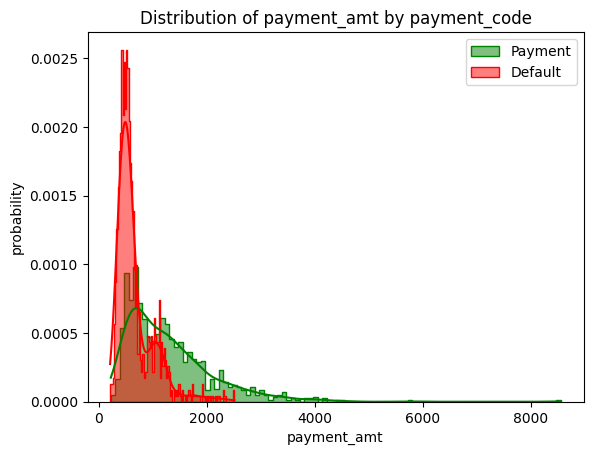

In [14]:
# Is there a statistical difference between payments with payment_code == 'PAYMENT' and payment_code == 'DEFAULT'
payment_df = merged_df[merged_df['payment_code'] == 'PAYMENT']
default_df = merged_df[merged_df['payment_code'] == 'DEFAULT']

# Generate random samples and calculate sample means for each dataframe
sample_size = 30
num_samples = 1000
payment_samples = [payment_df['payment_amt'].sample(sample_size, replace=True) for _ in range(num_samples)]
default_samples = [default_df['payment_amt'].sample(sample_size, replace=True) for _ in range(num_samples)]
payment_means = [sample.mean() for sample in payment_samples]
default_means = [sample.mean() for sample in default_samples]

# Plot Distributions
sns.histplot(payment_means, bins=100, kde=True, color='green', label='Payment', element='step', stat='density')
sns.histplot(default_means, bins=100, kde=True, color='red', label='Default', element='step', stat='density')
plt.xlabel('payment_amt')
plt.ylabel('probability')
plt.title('Distribution of payment_amt by payment_code')
plt.legend()


In [28]:
# Summary statistics for payments with payment_code = 'PAYMENT' and payment_code = 'DEFAULT'
payment_series = pd.Series(payment_means)
default_series = pd.Series(default_means)
print("Non-defaulted payments summary statistics", payment_series.describe(), sep ='\n')
print(' ')
print("Defaulted payments summary statistics", default_series.describe(), sep ='\n')

Non-defaulted payments summary statistics
count    1000.000000
mean     1293.787960
std       805.092136
min       226.711667
25%       697.209250
50%      1124.649667
75%      1674.669417
max      8558.093667
dtype: float64
 
Defaulted payments summary statistics
count    1000.000000
mean      664.307640
std       349.622391
min       213.227667
25%       442.199083
50%       549.367167
75%       745.034583
max      2514.924333
dtype: float64


In [16]:
# Is a certain entity_type more likely to have a payment_code = 'DEFAULT' compared to another?
default_by_entity_type_df = merged_df.groupby('entity_type').agg(
    percent_default=('payment_code', lambda x: (x == 'DEFAULT').mean() * 100),
    transactions_count=('payment_code', 'count')).reset_index()
default_by_entity_type_df


,entity_type,percent_default,transactions_count
0,Australian Private Company,8.195524,15057
1,Australian Proprietary Company,0.000000,4
2,Australian Public Company,12.500000,128
3,Discretionary Investment Trust,18.548387,124
4,Discretionary Trading Trust,11.229947,187
5,Family Partnership,4.483696,736
6,Fixed Unit Trust,0.000000,32
7,Hybrid Trust,6.250000,32
8,Individual/Sole Trader,9.567803,9417
9,Other Partnership,4.444444,135


In [29]:
# Comparison of mode of entity_year_established by entity_type where payment_code = 'DEFAULT' and payment_code = 'PAYMENT'
mode_entity_year_established_default_by_entity_type_df = merged_df[merged_df['payment_code'] == 'DEFAULT'].groupby('entity_type')['entity_year_established'].apply(lambda x: x.mode())
mode_entity_year_established_default_by_entity_type_df.columns = ['entity_type', 'mode_entity_year_established']
mode_entity_year_established_payment_by_entity_type_df = merged_df[merged_df['payment_code'] == 'PAYMENT'].groupby('entity_type')['entity_year_established'].apply(lambda x: x.mode())
mode_entity_year_established_payment_by_entity_type_df.columns = ['entity_type', 'mode_entity_year_established']
merged_mode_entity_year_established_df = pd.merge(mode_entity_year_established_default_by_entity_type_df, mode_entity_year_established_payment_by_entity_type_df, on='entity_type', suffixes=('_DEFAULT', '_PAYMENT')).reset_index()
merged_mode_entity_year_established_df

,entity_type,entity_year_established_DEFAULT,entity_year_established_PAYMENT
0,Australian Private Company,2015,2000
1,Australian Public Company,2013,2013
2,Discretionary Investment Trust,2015,2016
3,Discretionary Trading Trust,2013,2007
4,Family Partnership,2011,2000
5,Hybrid Trust,2007,2007
6,Individual/Sole Trader,2014,2000
7,Other Partnership,2000,2000


In [18]:
# Produce dataframe with all payment_code = 'PAYMENT' before first payment_code = 'DEFAULT' for each client_id contract.
default_client_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['client_id'].unique()
default_client_ids_df = merged_df[merged_df['client_id'].isin(default_client_ids)].reset_index()
filtered_df = default_client_ids_df.groupby(['entity_type', 'contract_id']).apply(lambda x: x.loc[:x[x['payment_code'] == 'DEFAULT'].index[0]-1] if 'DEFAULT' in x['payment_code'].values else x).reset_index(drop=True)

/tmp/ipykernel_63046/273903724.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = default_client_ids_df.groupby(['entity_type', 'contract_id']).apply(lambda x: x.loc[:x[x['payment_code'] == 'DEFAULT'].index[0]-1] if 'DEFAULT' in x['payment_code'].values else x).reset_index(drop=True)


Text(0.5, 1.0, 'Mean number of transactions before DEFAULT by entity_type')

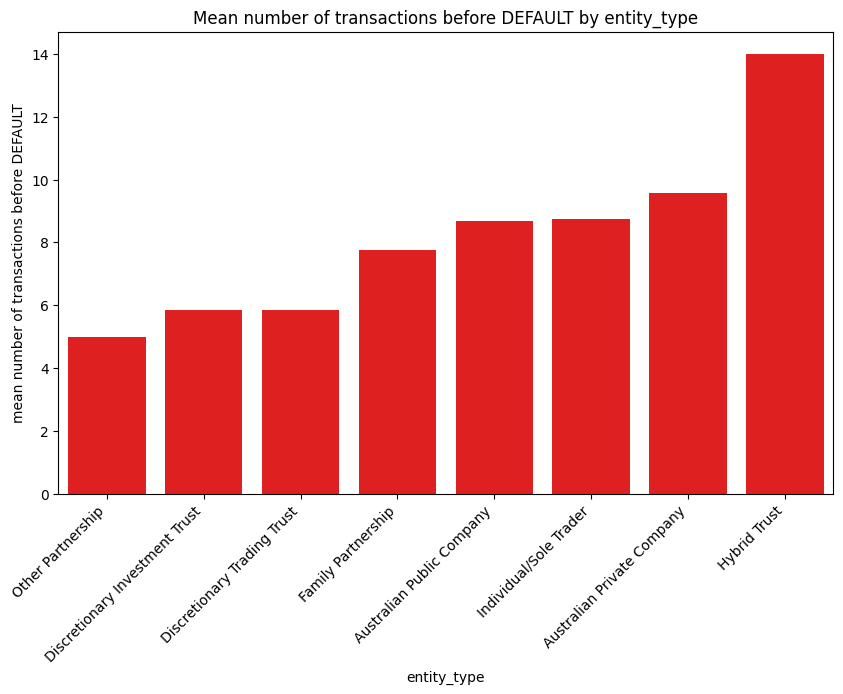

In [19]:
# Mean number of records before payment_code = 'DEFAULT' transaction for a contract by entity type
records_per_contract_by_entity_type = filtered_df.reset_index(drop = True).groupby(['entity_type', 'contract_id']).size()
mean_records_per_contract_by_entity_type = records_per_contract_by_entity_type.groupby('entity_type').mean().reset_index()
mean_records_per_contract_by_entity_type.columns = ['entity_type', 'mean number of transactions before DEFAULT']
mean_records_per_contract_by_entity_type_sorted_df = mean_records_per_contract_by_entity_type.sort_values(by='mean number of transactions before DEFAULT')
# Plot bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x='entity_type', y='mean number of transactions before DEFAULT', data=mean_records_per_contract_by_entity_type_sorted_df, color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Mean number of transactions before DEFAULT by entity_type')

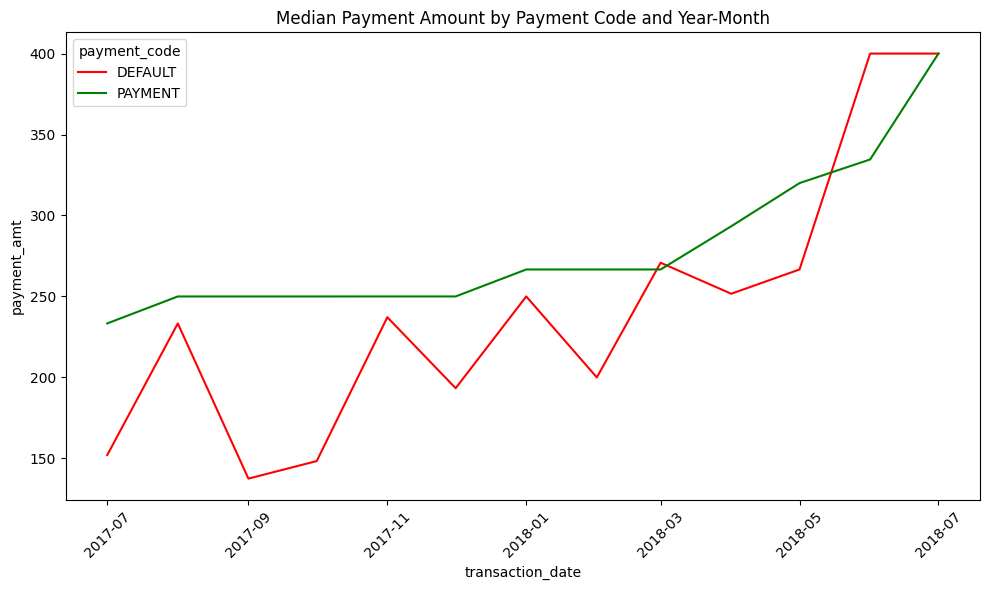

In [20]:
# Median payment amount payment_code = 'PAYMENT' and payment_code = 'DEFAULT' across time series
median_payment_amt_df = merged_df
median_payment_amt_df['transaction_date'] = merged_df['transaction_date'].dt.to_period('M')
median_payment_amt_df = median_payment_amt_df.groupby(['payment_code', 'transaction_date'])['payment_amt'].median().reset_index()
median_payment_amt_df['transaction_date'] = median_payment_amt_df['transaction_date'].dt.to_timestamp()
# Plot line graph
custom_palette = {'PAYMENT': 'green', 'DEFAULT': 'red'}
plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_date', y='payment_amt', hue='payment_code', palette=custom_palette, data=median_payment_amt_df)
plt.title('Median Payment Amount by Payment Code and Year-Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Summary Statistics of contract lengths for contracts with and without default payments
default_contract_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = merged_df[merged_df['contract_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = merged_df[~merged_df['contract_id'].isin(default_contract_ids)].reset_index()
default_contract_ids_df = default_contract_ids_df.groupby('contract_id')['transaction_date'].agg(['min', 'max'])
payment_contract_ids_df = payment_contract_ids_df.groupby('contract_id')['transaction_date'].agg(['min', 'max'])
default_contract_ids_df['min'] = default_contract_ids_df['min'].astype('datetime64[ns]')
default_contract_ids_df['max'] = default_contract_ids_df['max'].astype('datetime64[ns]')
payment_contract_ids_df['min'] = payment_contract_ids_df['min'].astype('datetime64[ns]')
payment_contract_ids_df['max'] = payment_contract_ids_df['max'].astype('datetime64[ns]')
default_contract_ids_df['contract_length'] = (default_contract_ids_df['max'] - default_contract_ids_df['min']) / pd.Timedelta(days=1)
payment_contract_ids_df['contract_length'] = (payment_contract_ids_df['max'] - payment_contract_ids_df['min']) / pd.Timedelta(days=1)
print('Summary statistics of contract lengths for contracts with default payments', default_contract_ids_df['contract_length'].describe(), sep='\n')
print(' ')
print('Summary statistics of contract lengths for contracts with no default payments', payment_contract_ids_df['contract_length'].describe(), sep='\n')

Summary statistics of contract lengths for contracts with default payments
count    378.000000
mean     190.616402
std      109.129390
min        0.000000
25%       92.000000
50%      184.000000
75%      274.000000
max      365.000000
Name: contract_length, dtype: float64
 
Summary statistics of contract lengths for contracts with no default payments
count    1265.000000
mean      134.926482
std       109.296167
min         0.000000
25%        31.000000
50%       120.000000
75%       242.000000
max       365.000000
Name: contract_length, dtype: float64


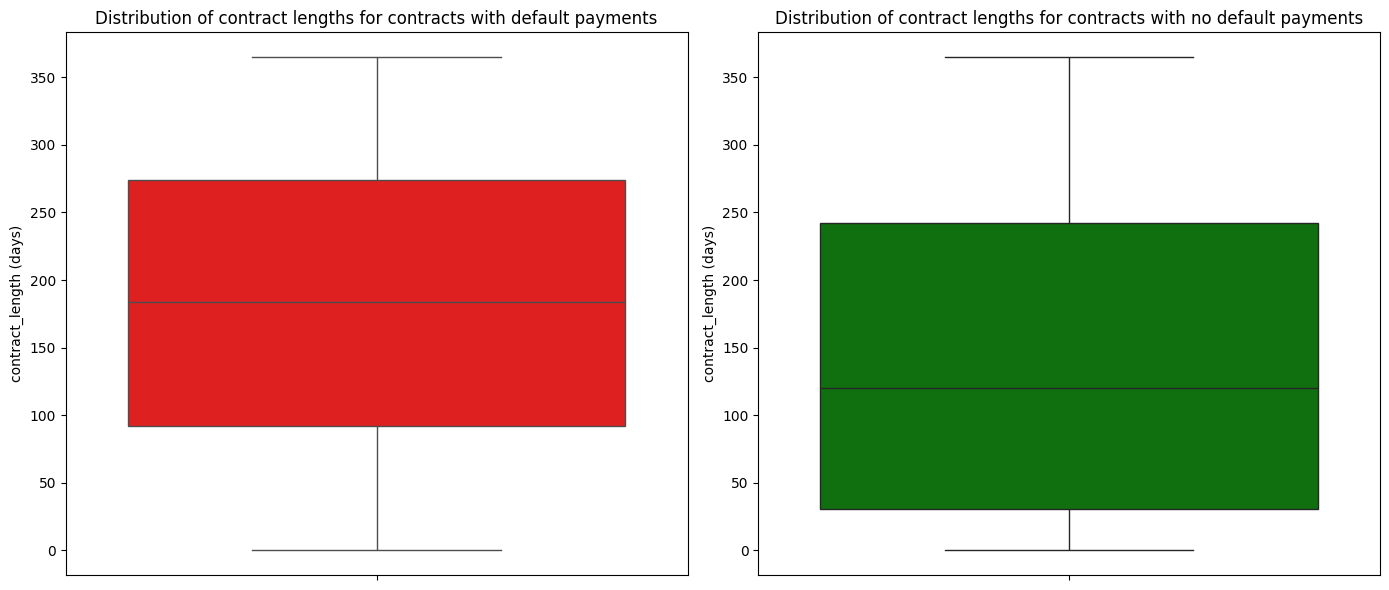

In [36]:
# Box plots representing distributions of contract lengths
fig,axes = plt.subplots(1,2, figsize=(14, 6))
sns.boxplot(y='contract_length', data=default_contract_ids_df, color='red', ax=axes[0])
axes[0].set_title('Distribution of contract lengths for contracts with default payments')
axes[0].set_ylabel('contract_length (days)')
sns.boxplot(y='contract_length', data=payment_contract_ids_df, color='green', ax=axes[1])
axes[1].set_title('Distribution of contract lengths for contracts with no default payments')
axes[1].set_ylabel('contract_length (days)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_63046/3788097143.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y='payment_amt', data=median_payment_amt_by_payment_code_df, estimator=np.median, palette=custom_palette)


Text(0.5, 1.0, 'Median payment_amt by status')

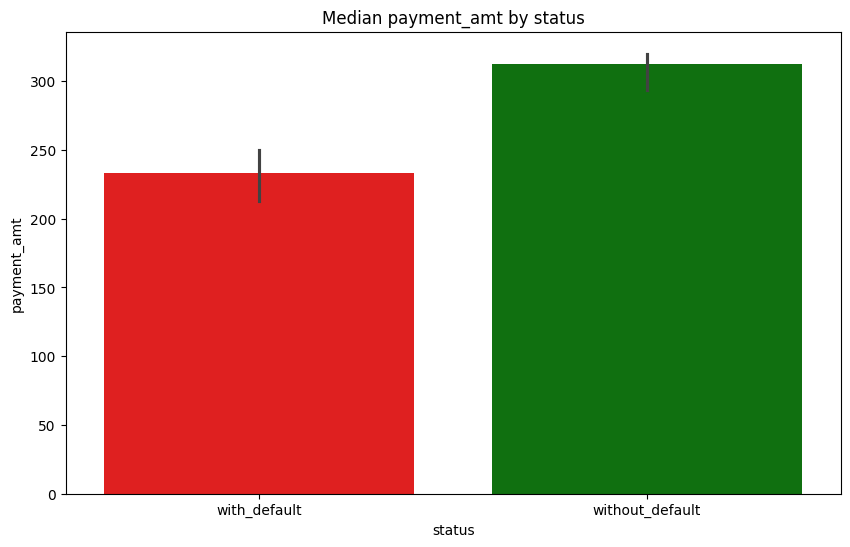

In [23]:
# Median payment_amt for contract without default payments vs with
default_contract_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = merged_df[merged_df['contract_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = merged_df[~merged_df['contract_id'].isin(default_contract_ids)].reset_index()
default_contract_ids_df['status'] = 'with_default'
payment_contract_ids_df['status'] = 'without_default'
median_payment_amt_by_payment_code_df = pd.concat([default_contract_ids_df, payment_contract_ids_df], ignore_index=True)
# Plot bar graph
custom_palette = {'with_default': 'red', 'without_default': 'green'}
plt.figure(figsize=(10, 6))
sns.barplot(x='status', y='payment_amt', data=median_payment_amt_by_payment_code_df, estimator=np.median, palette=custom_palette)
plt.title('Median payment_amt by status')

Text(0.5, 1.0, 'Mean contract_length by entity_type')

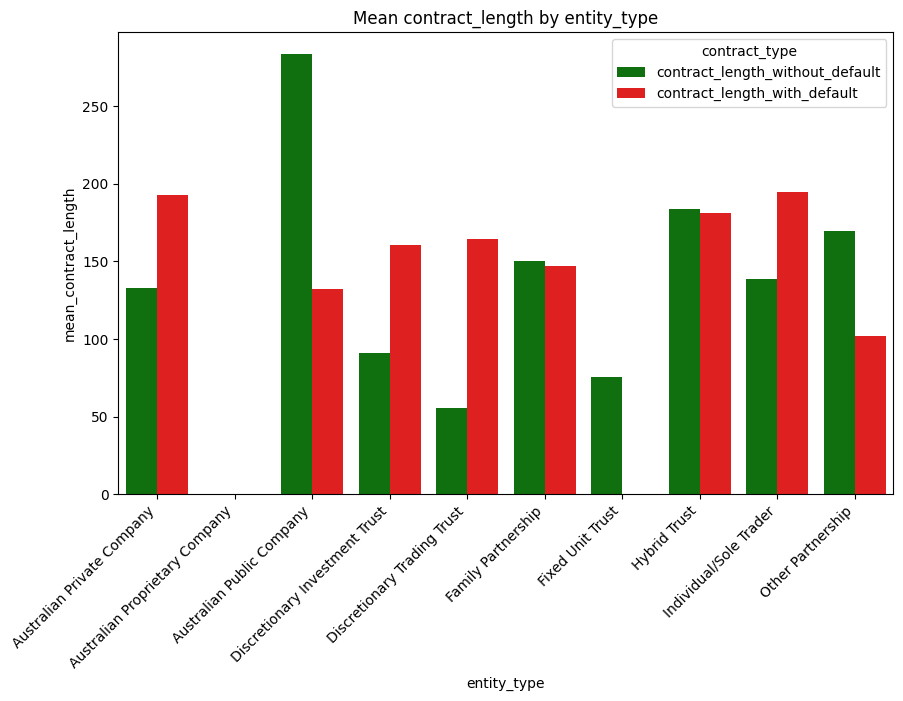

In [24]:
# Average contract length for different business entities for contracts with default payments and those without
default_contract_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = merged_df[merged_df['contract_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = merged_df[~merged_df['contract_id'].isin(default_contract_ids)].reset_index()
default_contract_ids_df = default_contract_ids_df.groupby(['entity_type', 'contract_id'])['transaction_date'].agg(['min', 'max'])
payment_contract_ids_df = payment_contract_ids_df.groupby(['entity_type', 'contract_id'])['transaction_date'].agg(['min', 'max'])
default_contract_ids_df['min'] = default_contract_ids_df['min'].astype('datetime64[ns]')
default_contract_ids_df['max'] = default_contract_ids_df['max'].astype('datetime64[ns]')
payment_contract_ids_df['min'] = payment_contract_ids_df['min'].astype('datetime64[ns]')
payment_contract_ids_df['max'] = payment_contract_ids_df['max'].astype('datetime64[ns]')
default_contract_ids_df['contract_length'] = (default_contract_ids_df['max'] - default_contract_ids_df['min'])  / pd.Timedelta(days=1)
payment_contract_ids_df['contract_length'] = (payment_contract_ids_df['max'] - payment_contract_ids_df['min'])  / pd.Timedelta(days=1)
average_time_difference_default_df = default_contract_ids_df.groupby('entity_type')['contract_length'].mean()
average_time_difference_payment_df = payment_contract_ids_df.groupby('entity_type')['contract_length'].mean()
combined_df = pd.concat([average_time_difference_payment_df, average_time_difference_default_df], axis=1)
combined_df.columns = ['contract_length_without_default', 'contract_length_with_default']
combined_df = combined_df.reset_index()
# Plot bar graph
combined_df_melt = pd.melt(combined_df, id_vars='entity_type', var_name='contract_type', value_name='mean_contract_length')
custom_palette = {'contract_length_without_default': 'green', 'contract_length_with_default': 'red'}
plt.figure(figsize=(10,6))
sns.barplot(data=combined_df_melt, x='entity_type', y='mean_contract_length', hue='contract_type', palette=custom_palette)
plt.xticks(rotation=45, ha='right')
plt.title('Mean contract_length by entity_type')


Text(0.5, 1.0, 'Mean number of defaults per contract with at least 1 default by entity_type')

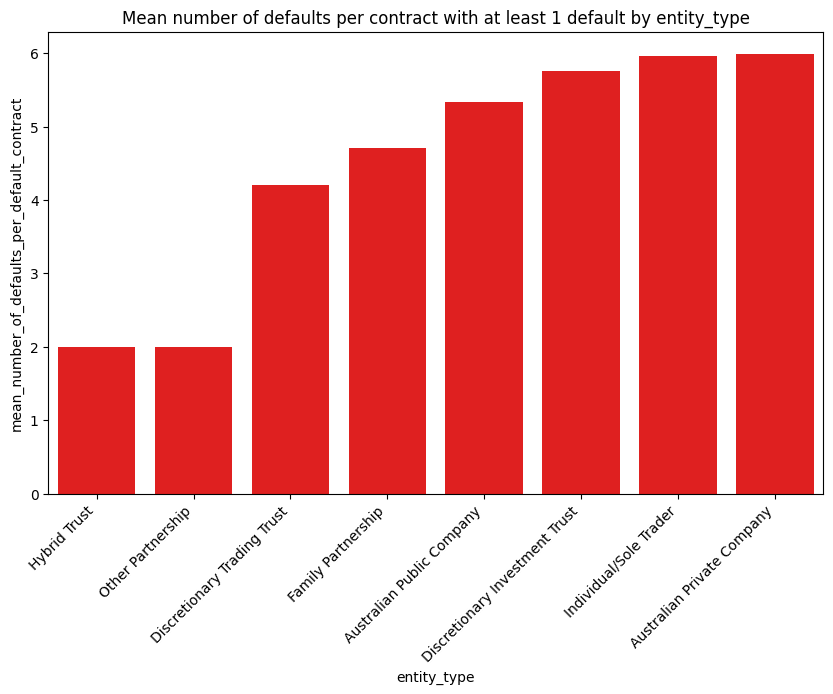

In [25]:
# Average number of default payments per contract for each entity_type
default_contract_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = merged_df[merged_df['contract_id'].isin(default_contract_ids)].reset_index()
default_payment_counts_df = default_contract_ids_df.groupby(['entity_type', 'contract_id'])['payment_code'].apply(lambda x: (x == 'DEFAULT').sum())
mean_default_payment_counts_df = default_payment_counts_df.groupby('entity_type').mean().reset_index()
mean_default_payment_counts_df.columns = ['entity_type', 'mean_number_of_defaults_per_default_contract']
mean_default_payment_counts_df_sorted = mean_default_payment_counts_df.sort_values(by='mean_number_of_defaults_per_default_contract')
plt.figure(figsize=(10,6))
sns.barplot(data=mean_default_payment_counts_df_sorted, x='entity_type', y='mean_number_of_defaults_per_default_contract', color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Mean number of defaults per contract with at least 1 default by entity_type')

Text(0.5, 1.0, 'Median total payment_amt by entity_type')

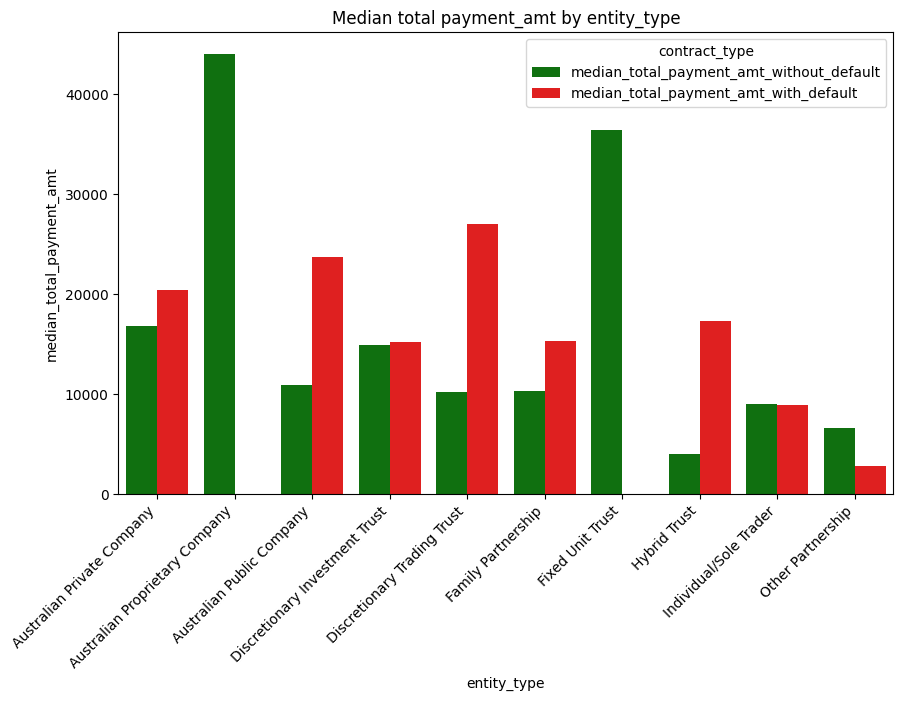

In [26]:
# Total transaction amount for life of contract with defaults vs without.
default_contract_ids = merged_df[merged_df['payment_code'] == 'DEFAULT']['contract_id'].unique()
default_contract_ids_df = merged_df[merged_df['contract_id'].isin(default_contract_ids)].reset_index()
payment_contract_ids_df = merged_df[~merged_df['contract_id'].isin(default_contract_ids)].reset_index()
default_contract_payment_amt_total_df = default_contract_ids_df.groupby(['entity_type', 'contract_id'])['payment_amt'].sum()
default_median_contract_payment_amt_total_df = default_contract_payment_amt_total_df.groupby('entity_type').median()
payment_contract_payment_amt_total_df = payment_contract_ids_df.groupby(['entity_type', 'contract_id'])['payment_amt'].sum()
payment_median_contract_payment_amt_total_df = payment_contract_payment_amt_total_df.groupby('entity_type').median()
combined_df = pd.concat([payment_median_contract_payment_amt_total_df, default_median_contract_payment_amt_total_df], axis=1)
combined_df.columns = ['median_total_payment_amt_without_default', 'median_total_payment_amt_with_default']
combined_df = combined_df.reset_index()
# Plot bar graph
combined_df_melt = pd.melt(combined_df, id_vars='entity_type', var_name='contract_type', value_name='median_total_payment_amt')
custom_palette = {'median_total_payment_amt_without_default': 'green', 'median_total_payment_amt_with_default': 'red'}
plt.figure(figsize=(10,6))
sns.barplot(data=combined_df_melt, x='entity_type', y='median_total_payment_amt', hue='contract_type', palette=custom_palette)
plt.xticks(rotation=45, ha='right')
plt.title('Median total payment_amt by entity_type')